In [1]:
import numpy as np
import pandas as pd
import json
import os
os.environ["OMP_NUM_THREADS"] = '1'


from langchain.prompts import PromptTemplate
from llama_index.embeddings.langchain import LangchainEmbedding
from langchain.embeddings import HuggingFaceEmbeddings

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from umap import umap_ as UMAP
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


In [2]:
from dotenv import load_dotenv
load_dotenv()

import os
import openai

openai_api_key = os.getenv("OPENAI_API_KEY")

openai.api_key = openai_api_key
client = openai.Client()

chat_model_name = 'gpt-4o-mini'
embedding_model_name = 'sentence-transformers/all-mpnet-base-v2'

s_root = r'C:\Users\fbohm\Desktop\Projects\DataScience\cluster_analysis/'
s_db_json = 'Data/survey_results_with_topics.json'

s_db_embed_json = 'Data/review_db_embed.json'
s_db_table_json = 'Data/review_db_table.json'
s_db_table_xlsx = 'Data/review_db_table.xlsx'
s_db_table_pca_json = 'Data/review_db_table_pca.json'
s_db_table_pca_xlsx = 'Data/review_db_table_pca.xlsx'
s_kmeans_centers = 'Data/kmeans_centers.json'
b_override = False

In [8]:

prompt_template_translation = PromptTemplate.from_template(
'''Please translate each section into English if it is not. The sections are separated by labels "REASON" and "WISH".

[h0]==================================================================[\h0]
REASON: "兄弟们，我把星空退款的钱拿来买这个了，我做的对吗"
WISH: "加动态模糊和垂直同步选项"

TRANSLATION:

REASON: "Brothers, I used the refund money from the stars to buy this. Did I do the right thing?"
WISH: "Add dynamic blur and vertical sync options."


[h0]==================================================================[\h0]
REASON: "My first D&D experience and I'm enjoying it a lot."
WISH: "I would like more guidance in the game."

TRANSLATION:

REASON: "My first D&D experience and I'm enjoying it a lot."
WISH: "I would like more guidance in the game."

[h0]==================================================================[\h0]
REASON: "{reason}"
WISH: "{wish}"

TRANSLATION:

'''
)

prompt_template_topic = PromptTemplate.from_template(
'''Please list the most important topics and their respective original context in the review of a game in a json format with "Topic", "Category", "Context" arguments.  No more than 10 topics.
Topics should be game features.  A feature in the game should be a noun rather than a verb or an adjective.
Each topic should be categorized as a "fact" or a "request".
Respond in JSON format.

[h0]==================================================================[\h0]
REVIEW: 

"The weapon durability in this game is frustrating; my sword breaks after just a few swings. The combat itself is fun, but I wish the durability lasted longer. Also, the audio effects are very immersive during battles."

TOPICS:

{{"Topics":
    [
        {{
            "Topic": "Weapon Durability",
            "Category": "request",
            "Context": "My sword breaks after just a few swings. I wish the durability lasted longer."
        }},
        {{
            "Topic": "Combat and Fighting",
            "Category": "fact",
            "Context": "The combat itself is fun."
        }},
        {{
            "Topic": "Audio",
            "Category": "fact",
            "Context": "The audio effects are very immersive during battles."
        }}
    ]
}}

[h0]==================================================================[\h0]
REVIEW: 

"Playing during the night adds a thrilling layer to the game. The lack of a proper save feature makes it hard to enjoy it though. Also, there are way too many random encounters that make progress difficult."

TOPICS:

{{"Topics":
    [
        {{
            "Topic": "Night",
            "Category": "fact",
            "Context": "Playing during the night adds a thrilling layer to the game."
        }},
        {{
            "Topic": "Save Feature",
            "Category": "request",
            "Context": "The lack of a proper save feature makes it hard to enjoy fully."
        }},
        {{
            "Topic": "Randomness",
            "Category": "request",
            "Context": "There are way too many random encounters that make progress difficult."
        }}
    ]
}}

[h0]==================================================================[\h0]
REVIEW: 

"{review}"

TOPICS:

'''
)

prompt_template_topic_view = PromptTemplate.from_template(
'''What's the sentiment of the review with regard to the topic?
Always answer with 'Positive' or 'Negative' or 'Inconclusive'.

REVIEW: My first D&D experience and I'm enjoying it a lot.
TOPIC: D&D
SENTIMENT: Positive 

REVIEW: This game lacks a proper ending or epilog
TOPIC: epilogue
SENTIMENT: Negative

REVIEW: Posted: August 8
TOPIC: release date
SENTIMENT: Inconclusive 

REVIEW: {review}
TOPIC: {topic}
SENTIMENT: '''
)

In [4]:
# Read in the JSON file with survey results 

with open(s_root + 'Data/survey_results_clean.json', 'r') as f:
    db = json.load(f)

## Translate reviews

In [30]:
import json
from lingua import Language, LanguageDetectorBuilder

# Load JSON data from file
input_file_path = 'Data/survey_results_clean.json'  # Adjust the path if needed
output_file_path = 'Data/survey_results_trans.json'  # New JSON with language and translations

# Initialize the language detector
detector = LanguageDetectorBuilder.from_languages(
    Language.ENGLISH, Language.SPANISH, Language.CHINESE, Language.GERMAN, Language.FRENCH
).build()

# Load JSON data
with open(input_file_path, 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)

# Process each entry
for entry in data:
    # Get the values for reason and wish fields, making sure NaNs are handled properly
    reason_text = entry.get("Please tell us why you chose the rating above:")
    wish_text = entry.get("If you had a magic wand and you could change, add, or remove anything from the game, what would it be and why?")

    # Initialize detected language as unknown
    detected_language = "unknown"
    
    # Determine language only for fields with actual text
    if isinstance(reason_text, str) and reason_text.strip():
        detected_language_reason = detector.detect_language_of(reason_text).name.lower()
    else:
        detected_language_reason = "none"

    if isinstance(wish_text, str) and wish_text.strip():
        detected_language_wish = detector.detect_language_of(wish_text).name.lower()
    else:
        detected_language_wish = "none"
    
    # Set the overall detected language based on valid fields
    if detected_language_reason != "none" and detected_language_reason == detected_language_wish:
        detected_language = detected_language_reason
    elif detected_language_reason != "none" and detected_language_reason != detected_language_wish:
        detected_language = "mixed"
    elif detected_language_reason != "none":
        detected_language = detected_language_reason
    elif detected_language_wish != "none":
        detected_language = detected_language_wish
    
    # Save the detected language in the JSON entry
    entry["language"] = detected_language

    # Only proceed with translation if:
    # - There is text in either reason_text or wish_text
    # - The detected language is not English
    if detected_language not in ["english", "none"]:
        # Prepare the prompt with only the fields that have text
        reason_text_for_prompt = reason_text if detected_language_reason != "none" else "N/A"
        wish_text_for_prompt = wish_text if detected_language_wish != "none" else "N/A"
        
        prompt_translation = prompt_template_translation.format(
            reason=reason_text_for_prompt, 
            wish=wish_text_for_prompt
        )

        # Make the OpenAI API call to translate the review
        response = client.chat.completions.create(
            model=chat_model_name,
            messages=[
                {"role": "system", "content": "You are a helpful assistant expertised in game review analysis."},
                {"role": "user", "content": prompt_translation},
            ],
            max_tokens=1024,
        )

        # Extract the translation response
        translation_response = response.choices[0].message.content

        # Update the entry only with translated text if present
        if "REASON:" in translation_response and detected_language_reason != "none":
            reason_translation = translation_response.split("REASON:")[1].split("WISH:")[0].strip()
            entry["Please tell us why you chose the rating above:"] = reason_translation

        if "WISH:" in translation_response and detected_language_wish != "none":
            wish_translation = translation_response.split("WISH:")[1].strip()
            entry["If you had a magic wand and you could change, add, or remove anything from the game, what would it be and why?"] = wish_translation

# Save the modified data with translations
with open(output_file_path, 'w', encoding='utf-8') as json_file:
    json.dump(data, json_file, indent=4, ensure_ascii=False)

print(f"Translated data saved to {output_file_path}")


Translated data saved to Data/survey_results_trans.json


## Extract Topics

In [9]:
with open(s_root + 'Data/survey_results_trans.json', 'r') as f:
    db = json.load(f)

entry = db[0]

# Extract important information from the 2nd and 3rd keys
review_text = entry["Please tell us why you chose the rating above:"]
additional_feedback = entry["If you had a magic wand and you could change, add, or remove anything from the game, what would it be and why?"]

# Combine both into a single review input for the prompt
combined_review = f"{review_text} {additional_feedback}"

# Format the prompt for the LLM
prompt_topic = prompt_template_topic.format(review=combined_review)

# Make the OpenAI API call
response = client.chat.completions.create(
    model=chat_model_name,
    messages=[
        {"role": "system", "content": "You are a helpful assistant expertised in game review analysis. Respond in JSON format."},
        {"role": "user", "content": prompt_topic},
    ],
    max_tokens=1024,
    response_format={
    "type": "json_object"
  }
)

# Print the response content
print(response.choices[0].message.content)

{
    "Topics": [
        {
            "Topic": "Difficulty",
            "Category": "fact",
            "Context": "It is a game that is inherently difficult due to survival and being concerned about resources."
        },
        {
            "Topic": "Resources",
            "Category": "fact",
            "Context": "Being concerned about resources makes the game interesting."
        },
        {
            "Topic": "Survival",
            "Category": "fact",
            "Context": "The game is inherently difficult due to survival."
        }
    ]
}


In [7]:
combined_review

'nan "I wouldnâ€™t take anything away from the game at the moment, because it is a game that is inherently difficult due to survival and being concerned about resources, which makes the game interesting since other zombie games do not have that like this one."'

## Sentiment Analysis

In [44]:
topic_response = response.choices[0].message.content
topics = json.loads(topic_response)

In [16]:
topics

{'Topics': [{'Topic': 'Room Access',
   'Category': 'request',
   'Context': 'Why can’t we access the rooms we cleared when we moved in?'},
  {'Topic': 'Space Management',
   'Category': 'request',
   'Context': 'You give us less space indoors once we move in.'},
  {'Topic': 'Movement Mechanics',
   'Category': 'fact',
   'Context': 'The moving in is weird.'}]}

In [17]:
# Iterate over each topic in the nested structure
for topic in topics['Topics']:
    topic_text = topic["Topic"]
    topic_context = topic["Context"]
    
    # Format the prompt for sentiment analysis
    prompt_sentiment = prompt_template_topic_view.format(review=topic_context, topic=topic_text)
    
    # Call the API for sentiment analysis
    sentiment_response = client.chat.completions.create(
        model=chat_model_name,
        messages=[
            {"role": "system", "content": "You are a helpful assistant expertised in sentiment analysis."},
            {"role": "user", "content": prompt_sentiment},
        ],
        max_tokens=1024,
    )
    
    # Extract the sentiment from the response
    sentiment = sentiment_response.choices[0].message.content.strip()
    
    # Ensure 'topics' key is initialized in the entry
    if "topics" not in entry:
        entry["topics"] = []

    # Append the topic information with sentiment to the "topics" list
    entry["topics"].append({
        "topic": topic_text,
        "context": topic_context,
        "category": topic["Category"],  # Add category from original data
        "sentiment": sentiment
    })

    # Print for confirmation
    print(f"Topic: {topic_text}\nContext: {topic_context}\nCategory: {topic['Category']}\nSentiment: {sentiment}\n")


2024-11-13 12:33:26,390 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Topic: Room Access
Context: Why can’t we access the rooms we cleared when we moved in?
Category: request
Sentiment: Negative



2024-11-13 12:33:26,816 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Topic: Space Management
Context: You give us less space indoors once we move in.
Category: request
Sentiment: Negative



2024-11-13 12:33:27,313 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Topic: Movement Mechanics
Context: The moving in is weird.
Category: fact
Sentiment: Negative



In [ ]:
output_file_path = s_root + 'Data/survey_results_with_topics.json'
with open(output_file_path, 'w', encoding='utf-8') as json_file:
    json.dump(db, json_file, indent=4, ensure_ascii=False)

## Everything put together 
### in a loop

In [14]:
import json
import logging
from langchain.prompts import PromptTemplate
from lingua import Language, LanguageDetectorBuilder

# Initialize the language detector
detector = LanguageDetectorBuilder.from_languages(
    Language.ENGLISH, Language.SPANISH, Language.CHINESE, Language.GERMAN, Language.FRENCH
).build()

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Initialize token counters
prompt_tokens = 0
completion_tokens = 0

# Load the survey results JSON file
input_file_path = s_root + 'Data/sample_size.json'
output_file_path = s_root + 'Data/sample_survey_results_with_topics.json'

with open(input_file_path, 'r', encoding='utf-8') as f:
    db = json.load(f)

# Initialize a counter for unique IDs
id_counter = 1

# Loop through each entry in the survey results
for entry in db:
    # Add a unique ID to the entry
    entry["ID"] = id_counter
    logging.info(f"Processing entry ID: {entry['ID']}")

    # Step 1: Detect language for each field and decide if translation is needed
    reason_text = entry.get("Please tell us why you chose the rating above:", "")
    wish_text = entry.get("If you had a magic wand and you could change, add, or remove anything from the game, what would it be and why?", "")
    
    # Initialize detected language as unknown
    detected_language = "unknown"
    
    # Detect language only for fields with actual text
    if isinstance(reason_text, str) and reason_text.strip():
        detected_language_reason = detector.detect_language_of(reason_text).name.lower()
    else:
        detected_language_reason = "none"

    if isinstance(wish_text, str) and wish_text.strip():
        detected_language_wish = detector.detect_language_of(wish_text).name.lower()
    else:
        detected_language_wish = "none"
    
    # Set the overall detected language based on valid fields
    if detected_language_reason != "none" and detected_language_reason == detected_language_wish:
        detected_language = detected_language_reason
    elif detected_language_reason != "none" and detected_language_reason != detected_language_wish:
        detected_language = "mixed"
    elif detected_language_reason != "none":
        detected_language = detected_language_reason
    elif detected_language_wish != "none":
        detected_language = detected_language_wish
    
    # Save the detected language in the JSON entry
    entry["language"] = detected_language

    # Only proceed to translation if:
    # - There is text in either reason_text or wish_text
    # - The detected language is not English
    if detected_language not in ["english", "none"]:
        # Prepare the translation prompt with only the fields that have text
        reason_text_for_prompt = reason_text if detected_language_reason != "none" else "N/A"
        wish_text_for_prompt = wish_text if detected_language_wish != "none" else "N/A"
        
        prompt_translation = prompt_template_translation.format(
            reason=reason_text_for_prompt, 
            wish=wish_text_for_prompt
        )

        # Make the OpenAI API call to translate the review
        translation_response = client.chat.completions.create(
            model=chat_model_name,
            messages=[
                {"role": "system", "content": "You are a helpful assistant for translation."},
                {"role": "user", "content": prompt_translation},
            ],
            max_tokens=1024,
        )
        
        # Track tokens used
        prompt_tokens += translation_response.usage.prompt_tokens
        completion_tokens += translation_response.usage.completion_tokens
        logging.info(f"Translation API call: Prompt tokens used: {translation_response.usage.prompt_tokens}, Completion tokens used: {translation_response.usage.completion_tokens}")

        # Parse and update entry with translated text, preserving original language info
        translation_text = translation_response.choices[0].message.content

        if "REASON:" in translation_text and detected_language_reason != "none":
            reason_translation = translation_text.split("REASON:")[1].split("WISH:")[0].strip()
            entry["Please tell us why you chose the rating above:"] = reason_translation

        if "WISH:" in translation_text and detected_language_wish != "none":
            wish_translation = translation_text.split("WISH:")[1].strip()
            entry["If you had a magic wand and you could change, add, or remove anything from the game, what would it be and why?"] = wish_translation

    # Rebuild combined_review with the updated (translated) values
    combined_review = f"{entry.get('Please tell us why you chose the rating above:', '')} {entry.get('If you had a magic wand and you could change, add, or remove anything from the game, what would it be and why?', '')}"

    # Step 2: Topic Extraction using the translated text
    prompt_topic = prompt_template_topic.format(review=combined_review)
    topic_response = client.chat.completions.create(
        model=chat_model_name,
        messages=[
            {"role": "system", "content": "You are a helpful assistant for game review analysis."},
            {"role": "user", "content": prompt_topic},
        ],
        max_tokens=1024,
        response_format={
            "type": "json_object"
          }
    )

    # Track tokens used
    prompt_tokens += topic_response.usage.prompt_tokens
    completion_tokens += topic_response.usage.completion_tokens
    logging.info(f"Topic Extraction API call: Prompt tokens used: {topic_response.usage.prompt_tokens}, Completion tokens used: {topic_response.usage.completion_tokens}")
    
    # Parse topics from JSON response
    topics = json.loads(topic_response.choices[0].message.content)  # JSON parse the response content

    # Initialize the "topics" key in the entry if it doesn't exist
    entry["topics"] = []

    # Step 3: Sentiment Analysis on each extracted topic
    for topic in topics["Topics"]:
        topic_text = topic["Topic"]
        topic_context = topic["Context"]
        topic_category = topic["Category"]  # Preserve "fact" or "request"

        prompt_sentiment = prompt_template_topic_view.format(review=topic_context, topic=topic_text)
        sentiment_response = client.chat.completions.create(
            model=chat_model_name,
            messages=[
                {"role": "system", "content": "You are a helpful assistant expertised in sentiment analysis."},
                {"role": "user", "content": prompt_sentiment},
            ],
            max_tokens=1024
        )
        
        # Track tokens used
        prompt_tokens += sentiment_response.usage.prompt_tokens
        completion_tokens += sentiment_response.usage.completion_tokens
        logging.info(f"Sentiment Analysis API call for topic '{topic_text}': Prompt tokens used: {sentiment_response.usage.prompt_tokens}, Completion tokens used: {sentiment_response.usage.completion_tokens}")

        sentiment = sentiment_response.choices[0].message.content.strip()
        
        # Append the topic information with sentiment and category to the "topics" list
        entry["topics"].append({
            "topic": topic_text,
            "sentiment": sentiment,
            "category": topic_category,
            "sentence": topic_context
        })
        
    logging.info(f"Completed processing entry ID: {entry['ID']}")
    
    # Increment the ID counter for the next entry
    id_counter += 1

# Save the final JSON with topics and sentiments
with open(output_file_path, 'w', encoding='utf-8') as json_file:
    json.dump(db, json_file, indent=4, ensure_ascii=False)

# Print or log the total tokens used
logging.info(f"Total prompt tokens used: {prompt_tokens}")
logging.info(f"Total completion tokens used: {completion_tokens}")
logging.info(f"Processed data with topics, sentiments, language info, and IDs saved to {output_file_path}")


2024-11-13 12:24:23,487 - INFO - Processing entry ID: 1
2024-11-13 12:24:27,425 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-13 12:24:27,425 - INFO - Topic Extraction API call: Prompt tokens used: 613, Completion tokens used: 215
2024-11-13 12:24:27,987 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-13 12:24:27,987 - INFO - Sentiment Analysis API call for topic 'Zombie Genre': Prompt tokens used: 145, Completion tokens used: 1
2024-11-13 12:24:28,508 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-13 12:24:28,508 - INFO - Sentiment Analysis API call for topic 'Game Difficulty': Prompt tokens used: 152, Completion tokens used: 1
2024-11-13 12:24:28,933 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-13 12:24:28,933 - INFO - Sentiment Analysis API call for topic 'Character Control': Prompt t

## Cost Calculation

In [15]:
#Usage and pricing for GPT4o-mini
total_prompt_cost = (prompt_tokens / 1_000_000) * 0.15
total_completion_cost = (completion_tokens / 1_000_000) * 0.6


print(f"Total prompt tokens used: {prompt_tokens}")
print(f"Total completion tokens used: {completion_tokens}")
print(f"Total prompt token cost: ${total_prompt_cost:.4f}")
print(f"Total completion token cost: ${total_completion_cost:.4f}")



Total prompt tokens used: 63375
Total completion tokens used: 8705
Total prompt token cost: $0.0095
Total completion token cost: $0.0052


In [18]:
# Read in the JSON file with survey results
with open(s_root + 'Data/sample_survey_results_with_topics.json', 'r', encoding='utf-8') as f:
    db = json.load(f)
    

## Embed the reviews
### Only the topics of the reviews

In [19]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Current CUDA device:", torch.cuda.current_device())
print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))


CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA GeForce GTX 1650 with Max-Q Design


In [23]:
embed_MiniLM = 'sentence-transformers/all-MiniLM-L6-v2'

embed_MPNET = 'sentence-transformers/all-mpnet-base-v2'

s_db_json = 'Data/survey_results_with_topics.json'
s_db_json_sample = 'Data/sample_survey_results_with_topics.json'

In [21]:
def index_embedding(text, model_name=embed_MiniLM):
    text = text.encode(encoding='ASCII', errors='ignore').decode()
    embed_model = LangchainEmbedding(
        HuggingFaceEmbeddings(model_name=model_name)
    )
    vector = embed_model.get_text_embedding(text)
    return vector

In [24]:
import gc

batch_size = 10  # Adjust based on available memory and dataset size
b_embedding = True

if b_embedding:
    with open(s_root + s_db_json_sample, 'r', encoding='utf-8') as f:
        d_review_output = json.load(f)
        print('Loaded JSON data')

    for batch_start in range(0, len(d_review_output), batch_size):
        batch_end = min(batch_start + batch_size, len(d_review_output))
        batch = d_review_output[batch_start:batch_end]
        
        for i, review_entry in enumerate(batch):
            print(f"Processing Review {i + batch_start + 1}")
            
            if isinstance(review_entry, dict) and 'topics' in review_entry and isinstance(review_entry['topics'], list):
                d_topics = review_entry['topics']
                
                for d_topic in d_topics:
                    if isinstance(d_topic, dict):
                        if 'embedding' not in d_topic or b_override:
                            if 'topic' in d_topic:
                                d_topic['embedding'] = index_embedding(d_topic['topic'])
                                
                                # Release memory
                                torch.cuda.empty_cache()
                                gc.collect()
                            else:
                                d_topic['embedding'] = 0
                print('.', end='')
        print(f"\nBatch {batch_start // batch_size + 1} processed.")

    # Save updated JSON with embeddings
    with open(s_root + s_db_embed_json, 'w', encoding='utf-8') as f:
        json.dump(d_review_output, f)
    print("Embeddings saved.")


2024-11-13 12:39:39,110 - INFO - Use pytorch device_name: cuda
2024-11-13 12:39:39,111 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 2


2024-11-13 12:39:41,816 - INFO - Use pytorch device_name: cuda
2024-11-13 12:39:41,816 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:39:44,541 - INFO - Use pytorch device_name: cuda
2024-11-13 12:39:44,541 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:39:47,697 - INFO - Use pytorch device_name: cuda
2024-11-13 12:39:47,697 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 3


2024-11-13 12:39:50,767 - INFO - Use pytorch device_name: cuda
2024-11-13 12:39:50,768 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:39:53,448 - INFO - Use pytorch device_name: cuda
2024-11-13 12:39:53,448 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:39:56,170 - INFO - Use pytorch device_name: cuda
2024-11-13 12:39:56,170 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 4


2024-11-13 12:39:59,051 - INFO - Use pytorch device_name: cuda
2024-11-13 12:39:59,051 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:40:01,720 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:01,721 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:40:04,406 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:04,407 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:40:07,188 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:07,188 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:40:09,812 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:09,813 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 5


2024-11-13 12:40:12,484 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:12,485 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:40:15,137 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:15,138 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:40:17,797 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:17,797 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:40:20,515 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:20,516 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:40:23,203 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:23,204 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:40:26,015 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:26,015 - INFO - Load pretrained SentenceTransformer: sentenc

.Processing Review 6


2024-11-13 12:40:36,851 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:36,852 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:40:39,648 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:39,648 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:40:42,362 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:42,362 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:40:45,005 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:45,005 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:40:47,657 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:47,657 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 7


2024-11-13 12:40:50,313 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:50,314 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:40:53,090 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:53,091 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:40:55,784 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:55,784 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:40:58,476 - INFO - Use pytorch device_name: cuda
2024-11-13 12:40:58,477 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:41:01,238 - INFO - Use pytorch device_name: cuda
2024-11-13 12:41:01,240 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:41:03,986 - INFO - Use pytorch device_name: cuda
2024-11-13 12:41:03,987 - INFO - Load pretrained SentenceTransformer: sentenc

.Processing Review 8


2024-11-13 12:41:17,435 - INFO - Use pytorch device_name: cuda
2024-11-13 12:41:17,436 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:41:20,258 - INFO - Use pytorch device_name: cuda
2024-11-13 12:41:20,258 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:41:22,923 - INFO - Use pytorch device_name: cuda
2024-11-13 12:41:22,923 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 9


2024-11-13 12:41:25,889 - INFO - Use pytorch device_name: cuda
2024-11-13 12:41:25,890 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:41:28,722 - INFO - Use pytorch device_name: cuda
2024-11-13 12:41:28,722 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:41:31,665 - INFO - Use pytorch device_name: cuda
2024-11-13 12:41:31,666 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:41:34,321 - INFO - Use pytorch device_name: cuda
2024-11-13 12:41:34,322 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:41:37,004 - INFO - Use pytorch device_name: cuda
2024-11-13 12:41:37,004 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 10


2024-11-13 12:41:39,714 - INFO - Use pytorch device_name: cuda
2024-11-13 12:41:39,714 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:41:42,416 - INFO - Use pytorch device_name: cuda
2024-11-13 12:41:42,417 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:41:45,258 - INFO - Use pytorch device_name: cuda
2024-11-13 12:41:45,259 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:41:48,068 - INFO - Use pytorch device_name: cuda
2024-11-13 12:41:48,068 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.
Batch 1 processed.
Processing Review 11
.Processing Review 12


2024-11-13 12:41:50,891 - INFO - Use pytorch device_name: cuda
2024-11-13 12:41:50,892 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:41:53,745 - INFO - Use pytorch device_name: cuda
2024-11-13 12:41:53,746 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:41:56,609 - INFO - Use pytorch device_name: cuda
2024-11-13 12:41:56,610 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:41:59,378 - INFO - Use pytorch device_name: cuda
2024-11-13 12:41:59,379 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:42:02,117 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:02,117 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 13
.Processing Review 14


2024-11-13 12:42:04,925 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:04,926 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:42:07,764 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:07,765 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:42:10,478 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:10,478 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:42:13,143 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:13,143 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:42:15,896 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:15,897 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 15


2024-11-13 12:42:18,729 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:18,730 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:42:21,418 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:21,419 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 16


2024-11-13 12:42:24,100 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:24,101 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:42:26,888 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:26,889 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:42:29,642 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:29,642 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:42:32,380 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:32,380 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:42:35,148 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:35,149 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:42:37,870 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:37,870 - INFO - Load pretrained SentenceTransformer: sentenc

.Processing Review 17


2024-11-13 12:42:43,344 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:43,344 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:42:46,110 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:46,110 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:42:48,777 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:48,777 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:42:51,553 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:51,554 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:42:54,192 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:54,192 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:42:56,928 - INFO - Use pytorch device_name: cuda
2024-11-13 12:42:56,928 - INFO - Load pretrained SentenceTransformer: sentenc

.Processing Review 18


2024-11-13 12:43:05,069 - INFO - Use pytorch device_name: cuda
2024-11-13 12:43:05,070 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:43:07,799 - INFO - Use pytorch device_name: cuda
2024-11-13 12:43:07,800 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:43:10,636 - INFO - Use pytorch device_name: cuda
2024-11-13 12:43:10,637 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:43:13,311 - INFO - Use pytorch device_name: cuda
2024-11-13 12:43:13,311 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:43:16,009 - INFO - Use pytorch device_name: cuda
2024-11-13 12:43:16,011 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 19


2024-11-13 12:43:18,652 - INFO - Use pytorch device_name: cuda
2024-11-13 12:43:18,653 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:43:21,481 - INFO - Use pytorch device_name: cuda
2024-11-13 12:43:21,482 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:43:24,158 - INFO - Use pytorch device_name: cuda
2024-11-13 12:43:24,159 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:43:26,927 - INFO - Use pytorch device_name: cuda
2024-11-13 12:43:26,927 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:43:29,734 - INFO - Use pytorch device_name: cuda
2024-11-13 12:43:29,734 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:43:32,548 - INFO - Use pytorch device_name: cuda
2024-11-13 12:43:32,548 - INFO - Load pretrained SentenceTransformer: sentenc

.Processing Review 20
.
Batch 2 processed.
Processing Review 21


2024-11-13 12:43:42,020 - INFO - Use pytorch device_name: cuda
2024-11-13 12:43:42,020 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:43:44,711 - INFO - Use pytorch device_name: cuda
2024-11-13 12:43:44,711 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:43:47,416 - INFO - Use pytorch device_name: cuda
2024-11-13 12:43:47,416 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:43:50,053 - INFO - Use pytorch device_name: cuda
2024-11-13 12:43:50,053 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:43:52,916 - INFO - Use pytorch device_name: cuda
2024-11-13 12:43:52,916 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:43:55,624 - INFO - Use pytorch device_name: cuda
2024-11-13 12:43:55,624 - INFO - Load pretrained SentenceTransformer: sentenc

.Processing Review 22


2024-11-13 12:43:58,307 - INFO - Use pytorch device_name: cuda
2024-11-13 12:43:58,307 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:44:01,423 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:01,424 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 23


2024-11-13 12:44:04,283 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:04,283 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:44:07,226 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:07,228 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:44:10,216 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:10,217 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:44:13,093 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:13,094 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:44:15,897 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:15,898 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 24


2024-11-13 12:44:18,685 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:18,686 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:44:21,361 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:21,362 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 25


2024-11-13 12:44:24,085 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:24,085 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:44:26,804 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:26,805 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 26


2024-11-13 12:44:29,469 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:29,469 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:44:32,160 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:32,160 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 27


2024-11-13 12:44:35,299 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:35,299 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:44:37,973 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:37,973 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 28


2024-11-13 12:44:40,650 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:40,650 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:44:43,337 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:43,337 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:44:46,044 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:46,044 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:44:48,731 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:48,731 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:44:51,524 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:51,524 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:44:54,259 - INFO - Use pytorch device_name: cuda
2024-11-13 12:44:54,259 - INFO - Load pretrained SentenceTransformer: sentenc

.Processing Review 29


2024-11-13 12:45:09,972 - INFO - Use pytorch device_name: cuda
2024-11-13 12:45:09,972 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:45:12,877 - INFO - Use pytorch device_name: cuda
2024-11-13 12:45:12,878 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:45:15,881 - INFO - Use pytorch device_name: cuda
2024-11-13 12:45:15,881 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:45:18,844 - INFO - Use pytorch device_name: cuda
2024-11-13 12:45:18,844 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 30


2024-11-13 12:45:21,895 - INFO - Use pytorch device_name: cuda
2024-11-13 12:45:21,899 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:45:24,742 - INFO - Use pytorch device_name: cuda
2024-11-13 12:45:24,742 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:45:27,567 - INFO - Use pytorch device_name: cuda
2024-11-13 12:45:27,583 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:45:30,376 - INFO - Use pytorch device_name: cuda
2024-11-13 12:45:30,376 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:45:33,308 - INFO - Use pytorch device_name: cuda
2024-11-13 12:45:33,308 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:45:35,996 - INFO - Use pytorch device_name: cuda
2024-11-13 12:45:35,996 - INFO - Load pretrained SentenceTransformer: sentenc

.
Batch 3 processed.
Processing Review 31


2024-11-13 12:45:38,846 - INFO - Use pytorch device_name: cuda
2024-11-13 12:45:38,846 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:45:41,692 - INFO - Use pytorch device_name: cuda
2024-11-13 12:45:41,695 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:45:44,859 - INFO - Use pytorch device_name: cuda
2024-11-13 12:45:44,859 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:45:47,620 - INFO - Use pytorch device_name: cuda
2024-11-13 12:45:47,636 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:45:50,612 - INFO - Use pytorch device_name: cuda
2024-11-13 12:45:50,612 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:45:53,721 - INFO - Use pytorch device_name: cuda
2024-11-13 12:45:53,721 - INFO - Load pretrained SentenceTransformer: sentenc

.Processing Review 32


2024-11-13 12:45:56,411 - INFO - Use pytorch device_name: cuda
2024-11-13 12:45:56,411 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:45:59,118 - INFO - Use pytorch device_name: cuda
2024-11-13 12:45:59,118 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:46:01,811 - INFO - Use pytorch device_name: cuda
2024-11-13 12:46:01,811 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 33


2024-11-13 12:46:04,566 - INFO - Use pytorch device_name: cuda
2024-11-13 12:46:04,566 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:46:07,318 - INFO - Use pytorch device_name: cuda
2024-11-13 12:46:07,318 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:46:10,061 - INFO - Use pytorch device_name: cuda
2024-11-13 12:46:10,061 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:46:12,867 - INFO - Use pytorch device_name: cuda
2024-11-13 12:46:12,867 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:46:15,692 - INFO - Use pytorch device_name: cuda
2024-11-13 12:46:15,692 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:46:18,346 - INFO - Use pytorch device_name: cuda
2024-11-13 12:46:18,346 - INFO - Load pretrained SentenceTransformer: sentenc

.Processing Review 34


2024-11-13 12:46:23,740 - INFO - Use pytorch device_name: cuda
2024-11-13 12:46:23,741 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:46:26,539 - INFO - Use pytorch device_name: cuda
2024-11-13 12:46:26,539 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:46:29,204 - INFO - Use pytorch device_name: cuda
2024-11-13 12:46:29,204 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:46:31,927 - INFO - Use pytorch device_name: cuda
2024-11-13 12:46:31,927 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 35


2024-11-13 12:46:34,730 - INFO - Use pytorch device_name: cuda
2024-11-13 12:46:34,730 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:46:38,571 - INFO - Use pytorch device_name: cuda
2024-11-13 12:46:38,571 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:46:41,205 - INFO - Use pytorch device_name: cuda
2024-11-13 12:46:41,205 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:46:44,003 - INFO - Use pytorch device_name: cuda
2024-11-13 12:46:44,003 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:46:46,727 - INFO - Use pytorch device_name: cuda
2024-11-13 12:46:46,727 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:46:50,023 - INFO - Use pytorch device_name: cuda
2024-11-13 12:46:50,023 - INFO - Load pretrained SentenceTransformer: sentenc

.Processing Review 36


2024-11-13 12:47:01,402 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:01,417 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:47:04,091 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:04,091 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:47:06,758 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:06,758 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:47:09,430 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:09,430 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:47:12,097 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:12,097 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 37


2024-11-13 12:47:15,338 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:15,338 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:47:18,260 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:18,260 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:47:20,938 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:20,938 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:47:23,664 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:23,664 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:47:26,280 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:26,280 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 38


2024-11-13 12:47:28,949 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:28,949 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:47:31,619 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:31,619 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:47:34,325 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:34,325 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:47:37,876 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:37,876 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:47:40,611 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:40,611 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 39


2024-11-13 12:47:43,275 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:43,275 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:47:46,015 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:46,015 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:47:48,671 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:48,671 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 40
.
Batch 4 processed.
Processing Review 41


2024-11-13 12:47:51,309 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:51,320 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:47:54,000 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:54,000 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 42
.Processing Review 43


2024-11-13 12:47:56,820 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:56,820 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:47:59,482 - INFO - Use pytorch device_name: cuda
2024-11-13 12:47:59,482 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 44


2024-11-13 12:48:02,117 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:02,117 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:48:04,953 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:04,953 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 45


2024-11-13 12:48:08,108 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:08,108 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:48:11,429 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:11,429 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:48:14,100 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:14,100 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:48:16,925 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:16,925 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:48:19,685 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:19,685 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:48:22,393 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:22,393 - INFO - Load pretrained SentenceTransformer: sentenc

.Processing Review 46


2024-11-13 12:48:28,273 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:28,273 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:48:30,951 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:30,951 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:48:33,651 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:33,651 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:48:36,322 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:36,322 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:48:42,845 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:42,845 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 47


2024-11-13 12:48:45,503 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:45,503 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:48:48,144 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:48,144 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:48:50,819 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:50,819 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:48:53,481 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:53,481 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:48:56,175 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:56,175 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.Processing Review 48


2024-11-13 12:48:59,263 - INFO - Use pytorch device_name: cuda
2024-11-13 12:48:59,263 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:49:01,975 - INFO - Use pytorch device_name: cuda
2024-11-13 12:49:01,975 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:49:04,767 - INFO - Use pytorch device_name: cuda
2024-11-13 12:49:04,768 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:49:07,458 - INFO - Use pytorch device_name: cuda
2024-11-13 12:49:07,458 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:49:10,108 - INFO - Use pytorch device_name: cuda
2024-11-13 12:49:10,108 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:49:12,881 - INFO - Use pytorch device_name: cuda
2024-11-13 12:49:12,881 - INFO - Load pretrained SentenceTransformer: sentenc

.Processing Review 49


2024-11-13 12:49:23,903 - INFO - Use pytorch device_name: cuda
2024-11-13 12:49:23,903 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:49:26,563 - INFO - Use pytorch device_name: cuda
2024-11-13 12:49:26,563 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:49:29,312 - INFO - Use pytorch device_name: cuda
2024-11-13 12:49:29,312 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:49:31,964 - INFO - Use pytorch device_name: cuda
2024-11-13 12:49:31,964 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:49:34,627 - INFO - Use pytorch device_name: cuda
2024-11-13 12:49:34,627 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:49:37,275 - INFO - Use pytorch device_name: cuda
2024-11-13 12:49:37,275 - INFO - Load pretrained SentenceTransformer: sentenc

.Processing Review 50


2024-11-13 12:49:42,622 - INFO - Use pytorch device_name: cuda
2024-11-13 12:49:42,622 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2024-11-13 12:49:45,328 - INFO - Use pytorch device_name: cuda
2024-11-13 12:49:45,328 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


.
Batch 5 processed.
Embeddings saved.


## Convert to Table
#### One review can have multiple topics. If we want a table structure, we need to have every topic in one row, essentially duplicating the review information.

In [25]:
import pandas as pd
import json

b_to_table = True

if b_to_table:
    # Initialize an empty DataFrame to hold all topics
    df_total = pd.DataFrame()
    
    # Load the JSON data with embeddings
    with open(s_root + s_db_embed_json, 'r', encoding='utf-8') as f:
        d_review_output = json.load(f)
        print("Loaded JSON with embeddings")

    # Iterate over each review entry in the JSON data
    for review_entry in d_review_output:
        # Check if 'topics' exists in each review entry
        if 'topics' in review_entry and isinstance(review_entry['topics'], list):
            # Create a DataFrame for the current review's topics
            df_gp = pd.DataFrame(review_entry['topics'])
            
            # Add additional columns from the review entry
            for key, value in review_entry.items():
                if key != 'topics':  # Skip the topics column itself
                    df_gp[key] = value  # Assign each additional field to each row in df_gp

            # Concatenate this review's DataFrame to the total DataFrame
            df_total = pd.concat([df_total, df_gp], ignore_index=True)
    
    # Save the combined DataFrame to JSON and Excel
    df_total.to_json(s_root + s_db_table_json, orient='records')
    df_total.to_excel(s_root + s_db_table_xlsx, index=False)
    print("Data saved to JSON and Excel")


Loaded JSON with embeddings
Data saved to JSON and Excel


## PCA

2024-11-13 12:53:42,331 - INFO - Use pytorch device_name: cuda
2024-11-13 12:53:42,331 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
C:\Users\fbohm\Documents\Venvironments\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


PCA
t-SNE
UMAP


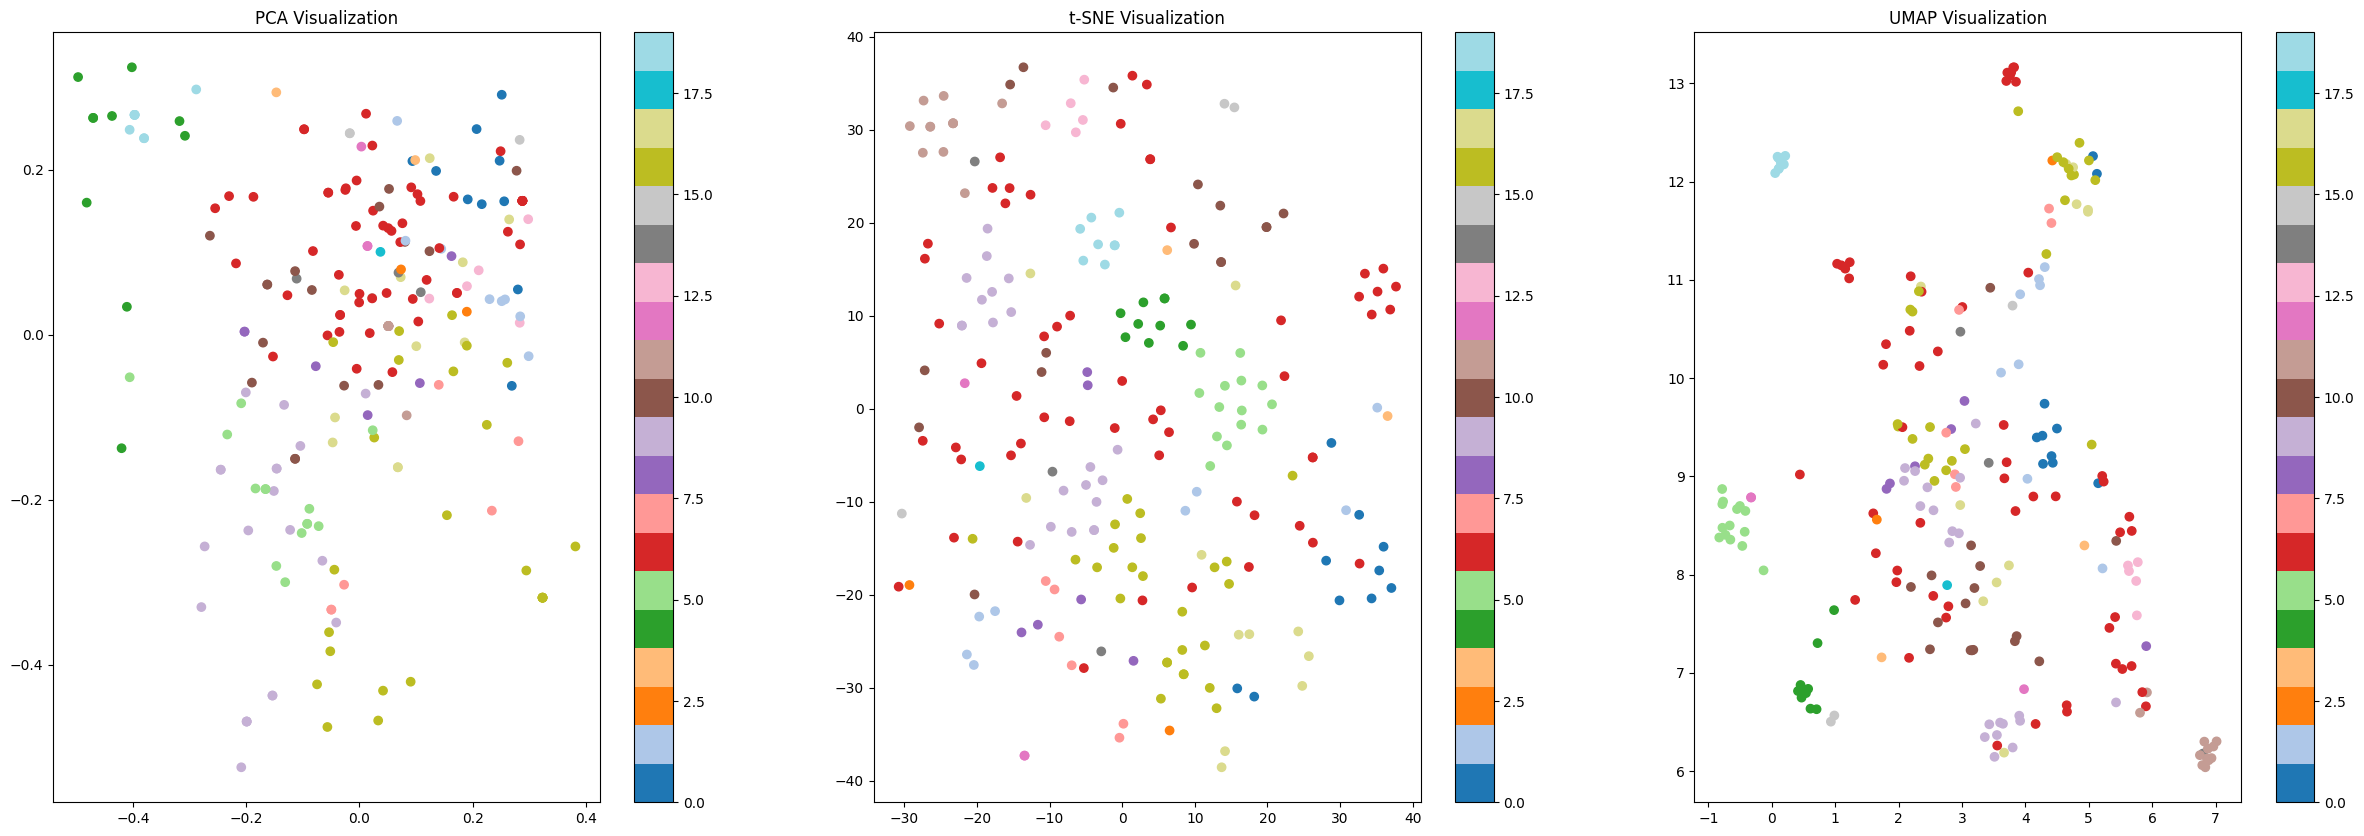

Clustering and dimensionality reduction results saved.


In [26]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
import matplotlib.pyplot as plt

b_pca_kmeans = True
b_update_kmeans_centers = True

if b_pca_kmeans:
    keyword = 'zombie'
    
    # Load existing K-means centers if available
    if os.path.isfile(s_root + s_kmeans_centers):
        with open(s_root + s_kmeans_centers, 'r') as f:
            d_kmeans_centers = json.load(f)
    else:
        d_kmeans_centers = {}

    # Load the DataFrame with embeddings
    df_total = pd.read_json(s_root + s_db_table_json, orient='records')
    df_total = df_total[df_total['embedding'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
    
    # Convert embeddings to matrix
    mat = np.array(df_total['embedding'].tolist())

    # Embed the keyword and compute similarity for each entry
    keyword_embed = index_embedding(keyword)
    df_total['similarity'] = mat @ keyword_embed  # Dot product for cosine similarity

    # Define number of clusters for main clustering and sub-clustering
    n_clusters = 20
    n_clusters_sub = 2
    s_key = str(n_clusters)
    
    # Initialize K-means clusters or use precomputed centers
    if s_key in d_kmeans_centers:
        mat_init = np.array(d_kmeans_centers[s_key])
    else:
        mat_init = np.zeros((n_clusters, mat.shape[1]))
        np.fill_diagonal(mat_init, 1.0)
    
    # Main K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, init=mat_init, n_init=1).fit(mat)
    df_total['kmeans'] = kmeans.labels_
    
    if b_update_kmeans_centers:
        d_kmeans_centers[s_key] = kmeans.cluster_centers_.tolist()

    # Sub-clustering for larger clusters
    df_total['kmeans_sub'] = 0
    for i_c in range(n_clusters):
        cluster_indices = np.where(df_total['kmeans'] == i_c)[0]
        if len(cluster_indices) > len(df_total) / n_clusters:
            mat_i_c = mat[cluster_indices, :]
            s_key_sub = f"{n_clusters}_{i_c}_{n_clusters_sub}"
    
            # Adjust n_clusters_sub if fewer samples than sub-clusters
            adjusted_n_clusters_sub = min(n_clusters_sub, len(mat_i_c))
    
            if s_key_sub in d_kmeans_centers and adjusted_n_clusters_sub == n_clusters_sub:
                mat_init_sub = np.array(d_kmeans_centers[s_key_sub])
            else:
                mat_init_sub = np.zeros((adjusted_n_clusters_sub, mat.shape[1]))
                np.fill_diagonal(mat_init_sub, 1.0)
    
            # Apply KMeans with adjusted number of clusters
            kmeans_sub = KMeans(n_clusters=adjusted_n_clusters_sub, init=mat_init_sub, n_init=1).fit(mat_i_c)
            df_total.loc[cluster_indices, 'kmeans_sub'] = kmeans_sub.labels_
    
            if b_update_kmeans_centers and adjusted_n_clusters_sub == n_clusters_sub:
                d_kmeans_centers[s_key_sub] = kmeans_sub.cluster_centers_.tolist()


    # Dimensionality Reduction Techniques
    methods = [
        ('PCA', PCA(n_components=3)),
        ('t-SNE', TSNE(n_components=2)),
        ('UMAP', UMAP(n_components=2))
    ]

    # Visualization
    plt.figure(figsize=(30, 10))
    for i, (name, model) in enumerate(methods):
        print(name)
        plt.subplot(1, 3, i + 1)

        if name == 'PCA':
            X_embedded = model.fit_transform(mat)
            df_total['first_dim_PCA'] = X_embedded[:, 0]
            df_total['second_dim_PCA'] = X_embedded[:, 1]
            df_total['third_dim_PCA'] = X_embedded[:, 2]
            plt.scatter(X_embedded[:, 1], X_embedded[:, 2], c=df_total['kmeans'], cmap='tab20')
        else:
            X_embedded = model.fit_transform(mat)
            df_total[f'first_dim_{name}'] = X_embedded[:, 0]
            df_total[f'second_dim_{name}'] = X_embedded[:, 1]
            plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=df_total['kmeans'], cmap='tab20')

        plt.title(f"{name} Visualization")
        plt.colorbar()

    plt.show()

    # Save K-means centers and DataFrame with clustering results
    with open(s_root + s_kmeans_centers, 'w') as f:
        json.dump(d_kmeans_centers, f)

    df_total.to_json(s_root + s_db_table_pca_json, orient='records')
    df_total.to_excel(s_root + s_db_table_pca_xlsx, index=False)
    print("Clustering and dimensionality reduction results saved.")


In [27]:
df_total.head()

,topic,sentiment,category,sentence,embedding,Please rate your overall experience playing Into the Dead: Our Darkest Days,Please tell us why you chose the rating above:,"If you had a magic wand and you could change, add, or remove anything from the game, what would it be and why?",Had you heard of Into the Dead before this demo?,What is your age group,...,similarity,kmeans,kmeans_sub,first_dim_PCA,second_dim_PCA,third_dim_PCA,first_dim_t-SNE,second_dim_t-SNE,first_dim_UMAP,second_dim_UMAP
0,Zombie Genre,Positive,fact,I love zombie games.,"[-0.056975618000000006, -0.0098000336, -0.0699...",10,I love zombie games; I all so love to play xco...,I feel that switching between charters just to...,Never heard of it,18-24,...,0.821075,19,0,0.114283,-0.380165,0.238394,-5.781329,19.336458,0.102589,12.241344
1,Game Difficulty,Positive,fact,"To the level of difficulty, the gameplay is ve...","[0.06499605630000001, 0.027713092, -0.04011411...",10,I love zombie games; I all so love to play xco...,I feel that switching between charters just to...,Never heard of it,18-24,...,0.239929,9,0,0.093868,-0.065471,-0.273776,-12.684023,-14.655321,2.343160,8.697660
2,Character Control,Negative,request,Switching between characters just to make them...,"[-0.0303811803, -0.0725035965, 0.0101754768, 0...",10,I love zombie games; I all so love to play xco...,I feel that switching between charters just to...,Never heard of it,18-24,...,0.209476,5,0,0.077987,-0.101981,-0.240196,13.367126,0.169160,-0.653688,8.356132
3,Task Menu,Inconclusive,request,Have it so you can click on a character and ha...,"[-0.042376481, 0.030017713100000003, -0.025849...",10,I love zombie games; I all so love to play xco...,I feel that switching between charters just to...,Never heard of it,18-24,...,0.051817,6,1,0.090209,0.261979,0.125055,-23.151539,-13.879292,4.045159,11.073575
4,Map Indicators,Negative,request,"If you fully looted and cleared an area, have ...","[0.0701220855, 0.046266265200000004, 0.0615224...",10,I love zombie games; I all so love to play xco...,I feel that switching between charters just to...,Never heard of it,18-24,...,0.012456,0,0,0.151275,0.279586,0.055069,18.177330,-30.976740,5.128237,12.079253


## HDBSCAN

In [29]:
import os
import json
import numpy as np
import pandas as pd
import umap
import hdbscan

# Paths and parameters
s_root = r'C:\Users\fbohm\Desktop\Projects\DataScience\cluster_analysis/'
s_db_table_json = 'Data/review_db_table.json'  # Input JSON with embeddings
s_db_table_hdbscan_json = 'Data/review_db_table_hdbscan.json'  # Output JSON with UMAP + HDBSCAN clusters
keyword = 'zombie'  # Keyword for similarity calculation

# Load DataFrame with embeddings
df_total = pd.read_json(s_root + s_db_table_json, orient='records')
df_total = df_total[df_total['embedding'].apply(lambda x: isinstance(x, list) and len(x) > 0)]

# Convert embeddings to matrix
mat = np.array(df_total['embedding'].tolist())

# Embed the keyword and compute similarity for each entry
def index_embedding(keyword):
    # Replace with the actual embedding function for your keyword
    return np.random.rand(mat.shape[1])

keyword_embed = index_embedding(keyword)
df_total['similarity'] = mat @ keyword_embed  # Dot product for cosine similarity

# UMAP Dimensionality Reduction (3D)
umap_model = umap.UMAP(n_components=3, random_state=42)
umap_embeddings = umap_model.fit_transform(mat)
df_total['umap_x'] = umap_embeddings[:, 0]
df_total['umap_y'] = umap_embeddings[:, 1]
df_total['umap_z'] = umap_embeddings[:, 2]  # Third dimension for optional 3D visualization

# HDBSCAN Clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3, cluster_selection_epsilon=0.5)
cluster_labels = clusterer.fit_predict(umap_embeddings)
df_total['cluster_id'] = cluster_labels

# Save DataFrame with UMAP and HDBSCAN results to JSON
df_total.to_json(s_root + s_db_table_hdbscan_json, orient='records')
print(f"3D UMAP and HDBSCAN clustering results with similarity saved to {s_root + s_db_table_hdbscan_json}")


C:\Users\fbohm\Documents\Venvironments\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


3D UMAP and HDBSCAN clustering results with similarity saved to C:\Users\fbohm\Desktop\Projects\DataScience\cluster_analysis/Data/review_db_table_hdbscan.json


In [30]:
df_total.head()

,topic,sentiment,category,sentence,embedding,Please rate your overall experience playing Into the Dead: Our Darkest Days,Please tell us why you chose the rating above:,"If you had a magic wand and you could change, add, or remove anything from the game, what would it be and why?",Had you heard of Into the Dead before this demo?,What is your age group,What is your gender?,What are your favourite Steam games you have played in the last 3 months?,ID,language,similarity,umap_x,umap_y,umap_z,cluster_id
0,Zombie Genre,Positive,fact,I love zombie games.,"[-0.056975618000000006, -0.0098000336, -0.0699...",10,I love zombie games; I all so love to play xco...,I feel that switching between charters just to...,Never heard of it,18-24,Man,"I would be resident evil 3,4,8 and world war z",1,english,0.856379,0.022370,3.786149,6.112730,0
1,Game Difficulty,Positive,fact,"To the level of difficulty, the gameplay is ve...","[0.06499605630000001, 0.027713092, -0.04011411...",10,I love zombie games; I all so love to play xco...,I feel that switching between charters just to...,Never heard of it,18-24,Man,"I would be resident evil 3,4,8 and world war z",1,english,0.417807,-3.601053,3.712209,5.207563,10
2,Character Control,Negative,request,Switching between characters just to make them...,"[-0.0303811803, -0.0725035965, 0.0101754768, 0...",10,I love zombie games; I all so love to play xco...,I feel that switching between charters just to...,Never heard of it,18-24,Man,"I would be resident evil 3,4,8 and world war z",1,english,0.281762,-4.318780,3.197578,8.200758,3
3,Task Menu,Inconclusive,request,Have it so you can click on a character and ha...,"[-0.042376481, 0.030017713100000003, -0.025849...",10,I love zombie games; I all so love to play xco...,I feel that switching between charters just to...,Never heard of it,18-24,Man,"I would be resident evil 3,4,8 and world war z",1,english,-0.136531,-5.636333,5.168213,6.394739,8
4,Map Indicators,Negative,request,"If you fully looted and cleared an area, have ...","[0.0701220855, 0.046266265200000004, 0.0615224...",10,I love zombie games; I all so love to play xco...,I feel that switching between charters just to...,Never heard of it,18-24,Man,"I would be resident evil 3,4,8 and world war z",1,english,-0.395747,-6.873899,5.304193,5.856551,8


## Name the Clusters

In [33]:
import os
import json
import numpy as np
import pandas as pd
import umap
import hdbscan
from sklearn.metrics.pairwise import cosine_distances

# Define paths and parameters
s_root = r'C:\Users\fbohm\Desktop\Projects\DataScience\cluster_analysis/'
s_db_table_hdbscan_json = 'Data/review_db_table_hdbscan.json'
keyword = 'zombie'  # Example keyword for similarity calculation

# Load precomputed data
df_total = pd.read_json(s_root + s_db_table_hdbscan_json, orient='records')
mat = np.array(df_total['embedding'].tolist())

# Step 1: Find Representative Topics for Each Cluster
cluster_names = {}
unique_clusters = df_total['cluster_id'].unique()

# Define a prompt template for cluster naming
prompt_template_cluster_naming = PromptTemplate.from_template(
'''Based on the following topics, generate a concise name (5 words or fewer) that best describes the general theme of this cluster.

TOPICS: {topics}
CLUSTER NAME: '''
)

def find_representative_topics(cluster_id, df, mat, max_topics=8):
    """Finds up to max_topics representative topics based on centroid proximity."""
    cluster_data = df[df['cluster_id'] == cluster_id]
    cluster_embeddings = np.array(cluster_data['embedding'].tolist())
    centroid = np.mean(cluster_embeddings, axis=0)
    distances = cosine_distances([centroid], cluster_embeddings).flatten()
    closest_indices = np.argsort(distances)[:max_topics]
    return cluster_data.iloc[closest_indices]['topic'].tolist()

# Step 2: Generate Cluster Names Using LLM
for cluster_id in unique_clusters:
    topics = find_representative_topics(cluster_id, df_total, mat)
    prompt = f"Generate a concise name (5 words or fewer) for a cluster with these topics: {', '.join(topics)}"
    
    # API call to generate cluster names
    def generate_cluster_name(topics_list):
        # Format topics as a comma-separated string
        topics = ", ".join(topics_list)
    
        # Generate the prompt for the cluster name
        prompt_cluster_naming = prompt_template_cluster_naming.format(topics=topics)
        
        # API call to OpenAI's completion model
        cluster_name_response = client.chat.completions.create(
            model=chat_model_name,
            messages=[
                {"role": "system", "content": "You are an expert at summarizing topics into concise names."},
                {"role": "user", "content": prompt_cluster_naming},
            ],
            max_tokens=100  # Adjust tokens to limit response length
        )
    
        # Extract and return the generated cluster name
        cluster_name = cluster_name_response.choices[0].message.content.strip()
        return cluster_name
    
    cluster_name = generate_cluster_name(prompt)
    cluster_names[cluster_id] = cluster_name

# Step 3: Save Cluster Names to JSON
df_total['cluster_name'] = df_total['cluster_id'].map(cluster_names)
df_total.to_json(s_root + s_db_table_hdbscan_json, orient='records')
print(f"Cluster names saved to {s_root + s_db_table_hdbscan_json}")


2024-11-13 14:58:59,861 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-13 14:59:00,436 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-13 14:59:00,896 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-13 14:59:01,816 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-13 14:59:02,398 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-13 14:59:03,460 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-13 14:59:03,841 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-13 14:59:04,407 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-13 14:59:04,900 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

Cluster names saved to C:\Users\fbohm\Desktop\Projects\DataScience\cluster_analysis/Data/review_db_table_hdbscan.json
